In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
from sklearn.decomposition import PCA
from cond_color import get_colors, plot_start, plot_end

In [34]:
np.random.seed(42)

Loading Data

In [35]:
data_orig = np.load('psths.npz')
X, times = data_orig['X'], data_orig['times']

# Exercise 1: Plotting raw PSTHs

In [36]:
def plot_psths(data, timeintervals, n_rows, n_cols, n_cond):
    np.random.seed(42)
    cond = np.random.randint(low=data.shape[1], size=n_cond)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,10))

    for row in ax:
        for col in row:
            n = np.random.randint(low=data.shape[0], size=1)[0]

            for c in cond:
                col.plot(timeintervals, data[n, c,:], label = 'C = '+str(c))
                col.set_title(f'Neuron {n}')
                col.legend()
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('Time relative to onset of hand movement')
    plt.ylabel('Trial-averaged spike rate (Hz)')

    plt.show()
    return

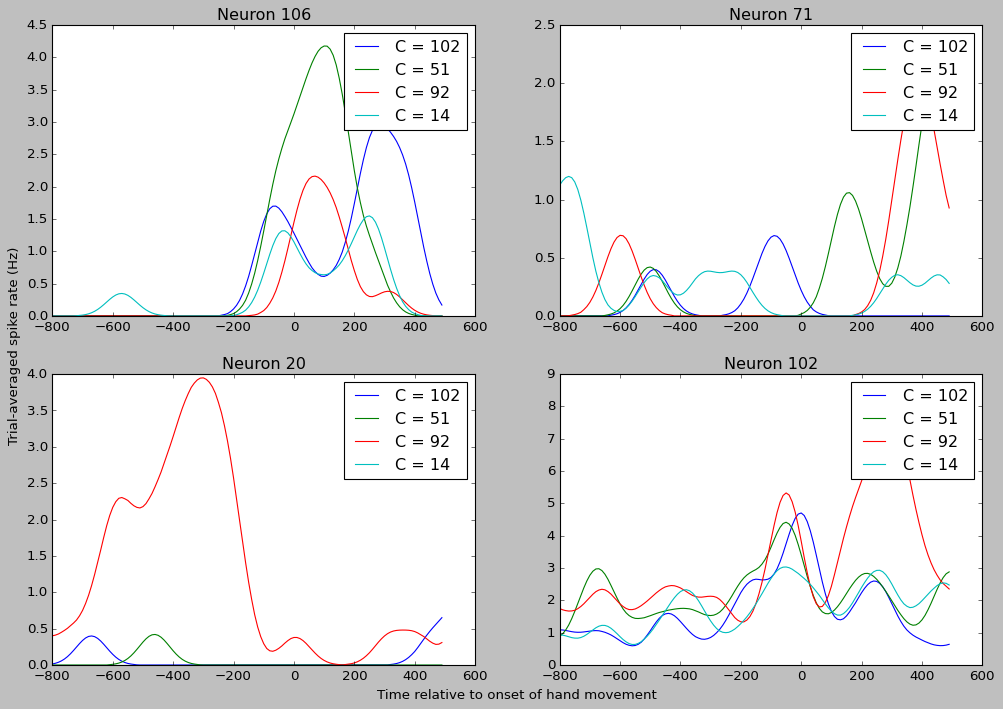

In [37]:
plot_psths(X, times, 2, 2, 4)

# Exercise 2: Pre-processing

## Normalisation

In [38]:
a, b = X.max(axis=(1,2)), X.min(axis=(1,2))
a, b = a.reshape(182,1,1), b.reshape(182,1,1)

X_norm = (X - b) / (a - b + 5 )

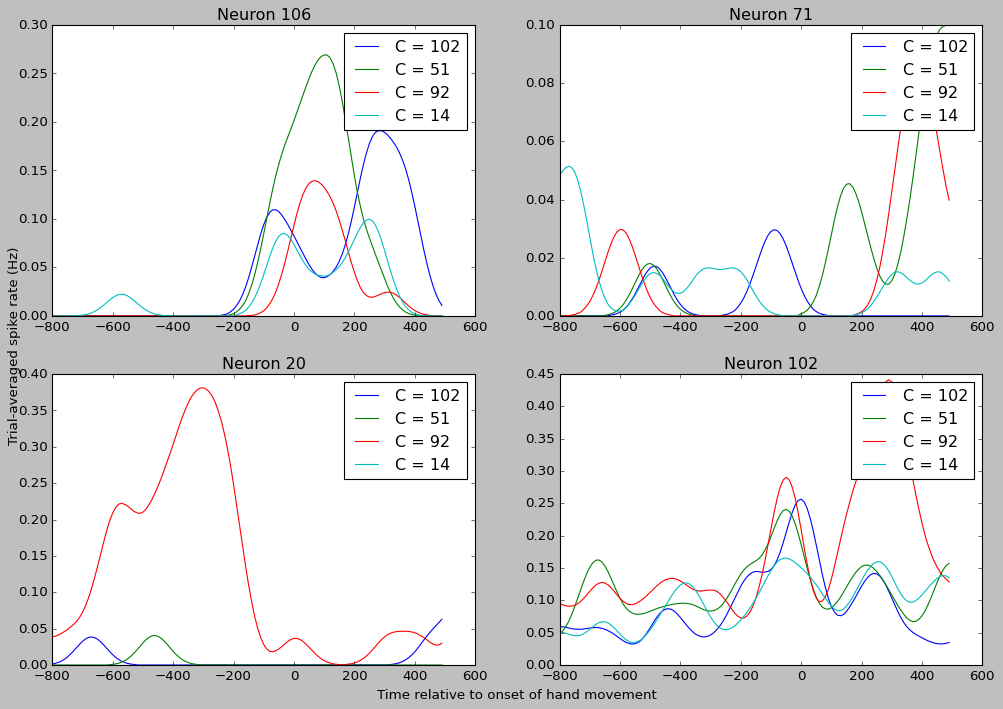

In [39]:
plot_psths(X_norm, times, 2, 2, 4)

## Mean centering

In [40]:
mean = X_norm.mean(axis=(0,2))
print(mean.shape)
mean = mean.reshape(1, 108, 1)
X_norm_mean = X_norm - mean

(108,)


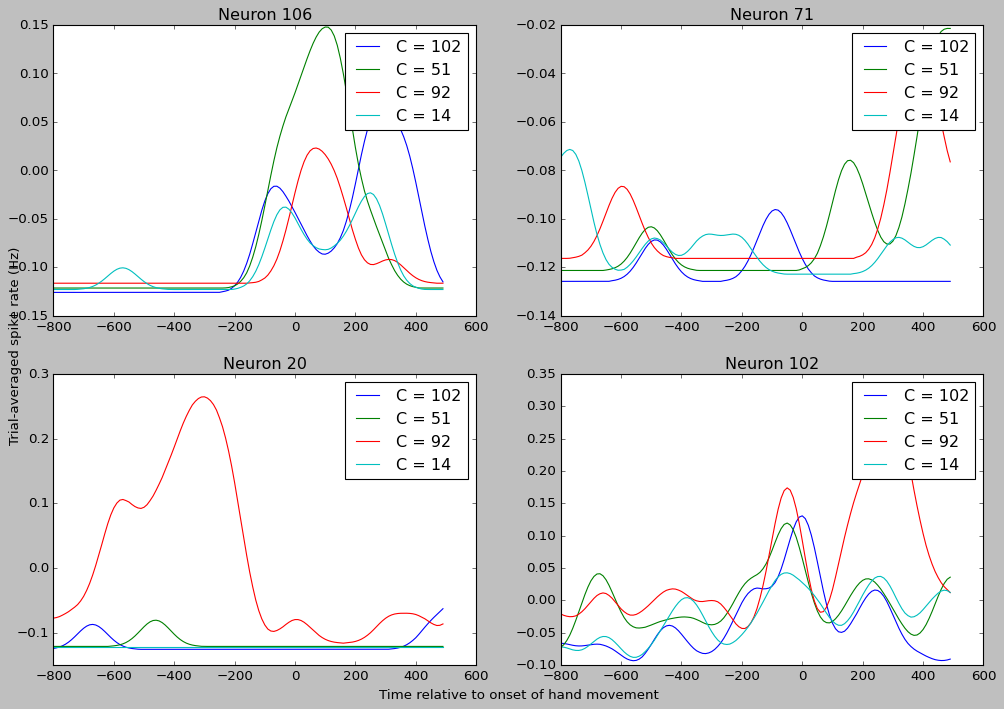

In [41]:
plot_psths(X_norm_mean, times, 2, 2, 4)

## Dimensionality reduction by PCA

In [42]:
# times = times[65:111]

In [43]:
X_trunc = X_norm_mean[:,:,65:111]
X = X_trunc.reshape(X_trunc.shape[0], X_trunc.shape[1]*X_trunc.shape[2])
print(X.shape)

(182, 4968)


In [44]:
pca = PCA(n_components=12)
pca.fit(X.T)
Z = pca.transform(X.T).T
print(Z.shape)

(12, 4968)


# Plotting PC space trajectorie

In [45]:
Z = Z.reshape(12, X_trunc.shape[1], X_trunc.shape[2])

In [46]:
def plot_pca_psths(data1, pca_axis_1, pca_axis_2, data2=None, alpha=1):
    np.random.seed(42)
    pca_axis_1 -= 1
    pca_axis_2 -= 1
    alt_colors = [False, True]

    for index, data in enumerate([data1, data2]):
        if data is not None:
            colors = get_colors(data[pca_axis_1, :, 0], data[pca_axis_2, :, 0], alt_colors[index//2])
            for cond in range(0, data.shape[1]):
                plt.plot(data[pca_axis_1, cond, :], data[pca_axis_2, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=alpha)
                plt.title(f'PCA plot')
                plt.xlabel(f'PCA - {pca_axis_1 + 1}')
                plt.ylabel(f'PCA - {pca_axis_2 + 1}')
            plot_start(data[pca_axis_1, :, 0], data[pca_axis_2, :, 0], colors, markersize=50, ax=None)
            plot_end(data[pca_axis_1, :, -1], data[pca_axis_2, :, -1], colors, markersize=50, ax=None)
        else:
            pass
    plt.show()
    return

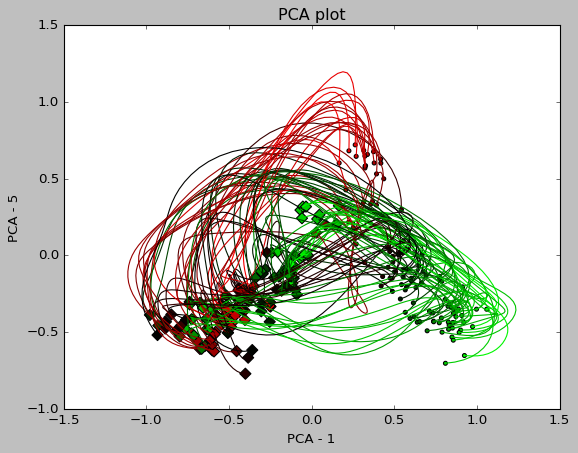

In [47]:
plot_pca_psths(Z, 1, 5)

# Exercise 4: Finding the max. likelihood estimate for A

## Log-likelihood and its (naive) gradient

$\Delta z_{t+1} = Az_{t} + \sigma \epsilon_t$ where $\sigma=1$

$\Delta z_{t+1} = N(Az_{t},I_{12\times12})$

$P(\Delta z_{1:T} | z_{0:T}) = \prod^T_{t=0}N(Az_{t},I_{12\times12})$

$log(P(\Delta z_{1:T} | z_{0:T})) = \sum^T_{t=0}log(N(Az_{t},I_{12\times12}))$

$log(P(\Delta z_{1:T} | z_{0:T})) \propto \sum^T_{t=0} log(\exp(-(\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t})))$

$log(P(\Delta z_{1:T} | z_{0:T})) \propto -\sum^T_{t=0} (\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t})$

$log(P(\Delta Z | Z)) \propto -(\Delta Z - AZ)^T(\Delta Z - AZ) \approx  - Z^TA^TAZ + 2\Delta Z^T A Z$

$\frac{d}{dA}(log(P(\Delta Z | Z))) = -2 Z^TA^TZ + 2\Delta Z^T  Z$

##  Parametrising an antisymmetric

K will equal 6, the number of matrix entries above the diagonal

$M \times M = 2K + M$

$K = \frac{M(M-1)}{2}$

In [48]:
beta = np.array([[0.0001, 1, 1, 0.0001, 1, 1]])

def create_h(m):
    k = int( (m**2 - m)/2)
    h = np.zeros((k, m, m))
    row, column = 0, 1
    for i in range(0, k):
        h[i][int(row)][int(column)], h[i][int(column)][int(row)] = 1, -1
        column += 1
        if column >= m:
            row += 1
            column = row + 1
    return h

H = create_h(4)
print(beta.shape)
print(H.shape)
print(H)

A = np.tensordot(beta, H, axes=1)
print(A)

(1, 6)
(6, 4, 4)
[[[ 0.  1.  0.  0.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [-1.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0. -1.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0. -1.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0. -1.  0.]]]
[[[ 0.e+00  1.e-04  1.e+00  1.e+00]
  [-1.e-04  0.e+00  1.e-04  1.e+00]
  [-1.e+00 -1.e-04  0.e+00  1.e+00]
  [-1.e+00 -1.e+00 -1.e+00  0.e+00]]]


# Gradient with respect to β

$log(P(\Delta Z | Z)) \approx  - (\sum^K_{a=1}\beta_a \sum^M_{j=1}H_{a,i,j}Z_{j,n})^T(\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n}) + 2\Delta Z^T (\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n})$

$log(P(\Delta Z | Z)) \approx  - (\sum^K_{a=1}\beta_a W_{a,i,n})^T(\sum^K_{a=1}\beta_aW_{a,i,n}) + 2\Delta Z^T (\sum^K_{a=1}\beta_aW_{a,i,n}) = - (\beta W)^T(\beta W) + 2\Delta Z^T (\beta W)$

$\frac{d}{d\beta}(log(P(\Delta Z | Z))) \approx - 2\beta W^TW + 2\Delta Z^T W$

$Q = W^TW$ and $b = \Delta Z^T W$

## An antisymmetric estimate for A

Solve $ \beta = b Q^{-1}$

In [49]:
def a_estimate(z):
    m = z.shape[0]
    z_plus, z_  = z[:,:,1:], z[:,:,:-1]
    z_plus = z_plus.reshape((m, z_plus.shape[1]*z_plus.shape[2]))
    z_ = z_.reshape((m, z_.shape[1]*z_.shape[2]))

    h = create_h(z_.shape[0])
    w = np.tensordot(h, z_, axes=1)
    q = np.tensordot(w, w, axes=([1,2],[1,2]))

    delta_z = z_plus - z_
    b = np.tensordot(delta_z, w, axes=([0,1],[1,2]))
    b = b.reshape((1,66))

    beta = b @ np.linalg.inv(q)
    a = np.tensordot(beta, h, axes=([1],[0]))
    a = a.reshape((m, m))
    return beta, a

In [50]:
beta, A = a_estimate(Z)

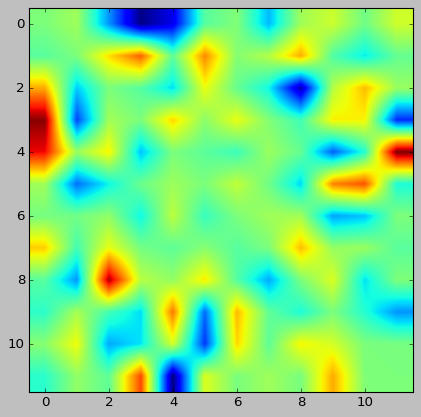

In [51]:
plt.imshow(A)

## Test

In [52]:
test = np.load('test.npz')
Z_test = test['Z_test']
A_test = test['A_test']

In [53]:
beta_test_estimated, A_test_estimated = a_estimate(Z_test)

In [54]:
A_inaccuracy = (A_test_estimated - A_test).max()
print(A_inaccuracy)

2.6940888755988546e-12


# Exercise 5: 2D projections with rotational dynamics

## A) Eigenvalues and Eigenvectors of A

In [55]:
A_evalue, A_evector = np.linalg.eig(A)
print(A_evector)

[[-4.22566939e-02+0.22773704j -4.22566939e-02-0.22773704j
   6.19611536e-02+0.44930187j  6.19611536e-02-0.44930187j
  -3.17482064e-01+0.25097329j -3.17482064e-01-0.25097329j
   9.56954732e-02-0.18269539j  9.56954732e-02+0.18269539j
  -1.54362526e-01-0.00129108j -1.54362526e-01+0.00129108j
   1.80632112e-02+0.10082383j  1.80632112e-02-0.10082383j]
 [-1.31776705e-01-0.30152729j -1.31776705e-01+0.30152729j
  -5.82168758e-02-0.1360644j  -5.82168758e-02+0.1360644j
   4.24102942e-02+0.16876657j  4.24102942e-02-0.16876657j
   1.89583481e-02-0.14966476j  1.89583481e-02+0.14966476j
  -5.10932522e-01+0.j         -5.10932522e-01-0.j
  -2.30990133e-01-0.04863371j -2.30990133e-01+0.04863371j]
 [ 2.93758213e-01-0.06247254j  2.93758213e-01+0.06247254j
   2.45965360e-01+0.22347277j  2.45965360e-01-0.22347277j
   2.20618898e-04-0.29683602j  2.20618898e-04+0.29683602j
  -1.41995726e-01-0.11835606j -1.41995726e-01+0.11835606j
  -6.56606479e-02+0.20660766j -6.56606479e-02-0.20660766j
  -2.27263473e-01-0.2

## B)

In [56]:
def get_p(eigen_vectors, plane):
    evector_real = eigen_vectors[:,plane].real
    evector_imag = eigen_vectors[:,plane].imag
    p = np.zeros((2, 12))
    p[0, :] = evector_real/np.linalg.norm(evector_real)
    p[1, :] = evector_imag/np.linalg.norm(evector_imag)
    print(p[0, :].T @ p[1, :])
    return p

In [57]:
P_FR = get_p(A_evector, 0)

-3.2439329000766293e-16


## C)

In [58]:
Projection_FR = np.tensordot(P_FR, Z, axes=([1],[0]))

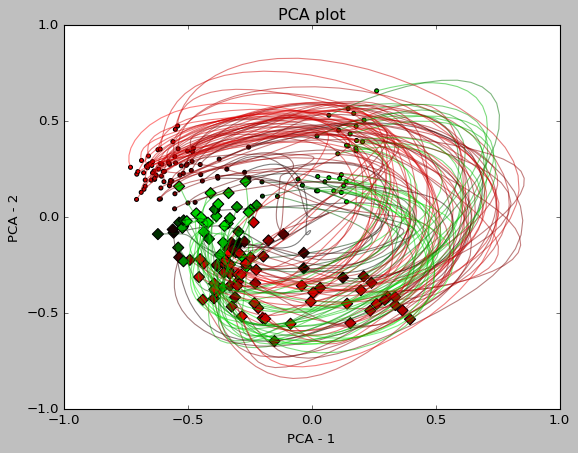

In [59]:
plot_pca_psths(Projection_FR[:,:,:], 1, 2, alpha=0.5)

## D)

-1.5265566588595902e-16


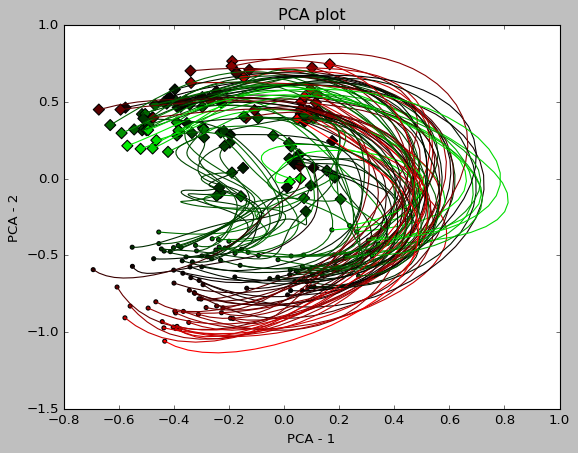

In [60]:
P_2 = get_p(A_evector, 3)
Projection_2 = np.tensordot(P_2, Z, axes=([1], [0]))
plot_pca_psths(Projection_2[:, :, 0:36], 1, 2)

7.251144129583054e-16


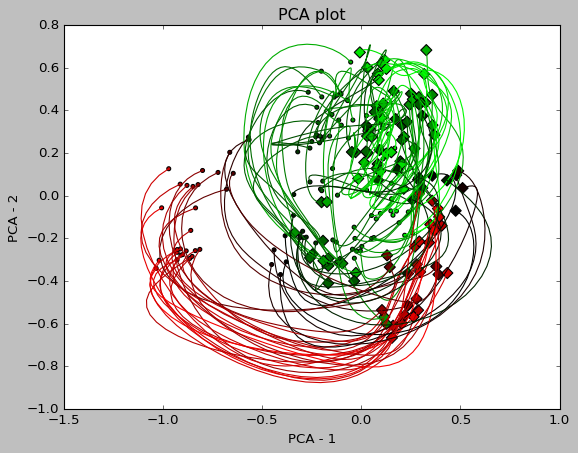

In [61]:
P_3 = get_p(A_evector, 5)
Projection_3 = np.tensordot(P_3, Z, axes=([1], [0]))
plot_pca_psths(Projection_3[:, :, 0:36], 1, 2)

# Exercise 6: Pre-movement period

In [62]:
X_pre = X_norm_mean[:, :, :66]
X = X_pre.reshape(X_pre.shape[0], X_pre.shape[1] * X_pre.shape[2])
print(X.shape)
Z_pre = pca.transform(X.T).T
Z_pre = Z_pre.reshape(12 , X_pre.shape[1], X_pre.shape[2])
print(Z_pre.shape)
Projection_FR_pre = np.tensordot(P_FR, Z_pre, axes=([1], [0]))

(182, 7128)
(12, 108, 66)


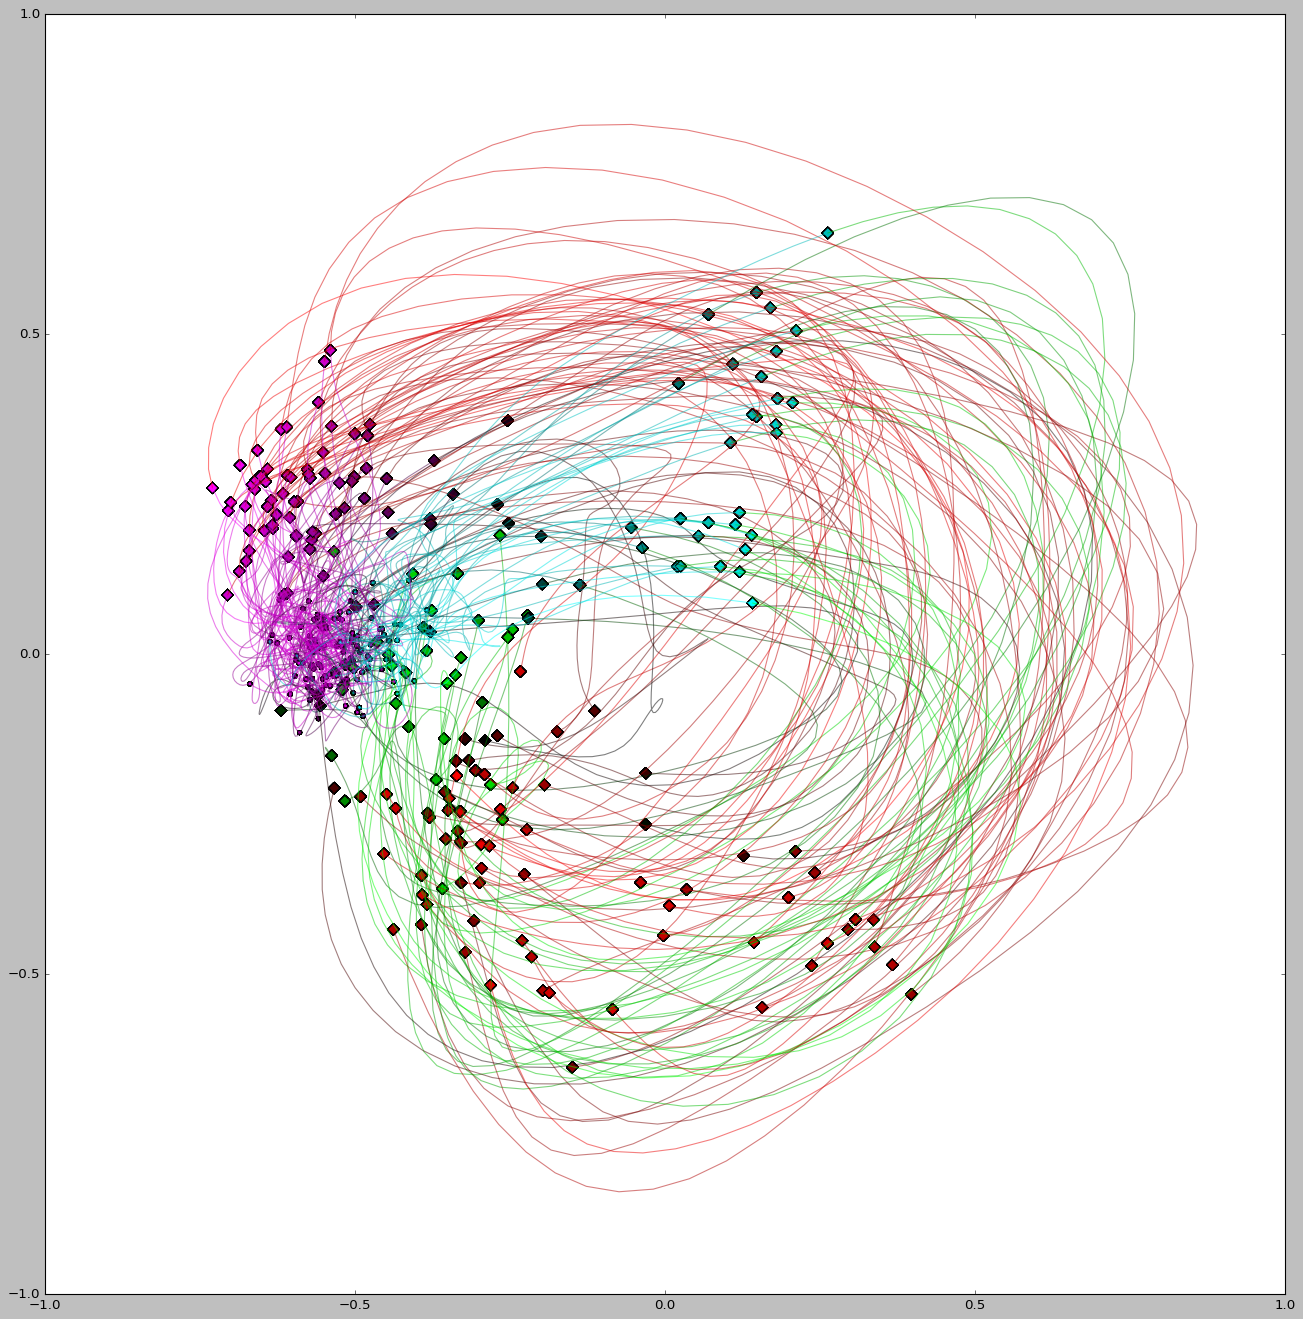

In [63]:
plt.figure(figsize=(20, 20))
data = Projection_FR
colors = get_colors(data[0, :, 0], data[1, :, 0], alt_colors=False)
for cond in range(0, data.shape[1]):
    plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.5)
    plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
    plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)

data = Projection_FR_pre
colors = get_colors(data[0, :, -1], data[1, :, -1], alt_colors=True)
for cond in range(0, data.shape[1]):
    plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.5)
    plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
    plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)

plt.show()